Reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/09.%20Clustering%20Grocery%20Items.ipynb

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do:

- 1) The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
 - the customer who bought the most items overall in her lifetime
 - for each item, the customer who bought that product the most

- 2) Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
item_to_id = pd.read_csv('./item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
# 48 items are represented in the dataset

item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Item_name    48 non-null object
Item_id      48 non-null int64
dtypes: int64(1), object(1)
memory usage: 840.0+ bytes


In [4]:
# No zero entries

item_to_id.isnull().sum()

Item_name    0
Item_id      0
dtype: int64

In [5]:
print(sorted(item_to_id.Item_id.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [6]:
# History of purchases

history = pd.read_csv('./purchase_history.csv')
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [7]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
user_id    39474 non-null int64
id         39474 non-null object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [8]:
history.isnull().sum()

user_id    0
id         0
dtype: int64

### Data Processing

We need to build user-item matrix

In [9]:
def item_count(df):
    """ function to convert id into counts """
    
    all_item_ids = df['id'].str.split(',').sum() # siply split the id columns
    unique_items_list = [0 for i in range(1, len(item_to_id)+1)] # array of 48 zeros
    
    for i in all_item_ids:
        
        unique_items_list[int(i)-1] += 1
        
    return pd.Series(unique_items_list, index=list(range(1, 49)))

In [10]:
# get user_item count matrix
user_item_count = history.groupby('user_id').apply(item_count)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


### Question 1

**The customers (let show top-5) who bought the most items overall in her lifetime**

In [11]:
user_count_df = user_item_count.sum(axis=1).reset_index().rename(columns={0:'count'})
user_count_df.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


**Now show each item, the customer who bought that product the most**

In [12]:
# Return the user id who acquitred at most (np.argmax) each item 

item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id',0:'User_id'})
item_user_most.head()


,Item_id,User_id
0,1,31625
1,2,31625
2,3,154960
3,4,5289
4,5,217277


In [13]:
df = pd.merge(left = item_user_most, right = item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]


,Item_id,Item_name,User_id
0,1,sugar,31625
1,2,lettuce,31625
2,3,pet items,154960
3,4,baby items,5289
4,5,waffles,217277
5,6,poultry,334664
6,7,sandwich bags,175865
7,8,butter,151926
8,9,soda,269335
9,10,carrots,618914


### Question 2
Items Clustering

In [14]:
# define the feature matrix: item_id, user_id
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The next step is to determine the optimal amount of clusters. There is no real algorithm to do so, therefore in most of the cases the number of clusters
is chosen empirically by looking at the dependency between the value of a cost function and the number of clusters.

In [15]:
clusters = range(2, 30)
inertias = []
silhouettes = [] # lower is better

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

ref: https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic07_unsupervised/topic7_pca_clustering.ipynb?flush_cache=true


**Silhouette**

In contrast to the metrics described above, this coefficient does not imply the knowledge about the true labels of the objects. It lets us estimate the quality of the clustering using only the initial, unlabeled sample and the clustering result. To start with, for each observation, the silhouette coefficient is computed. Let a be the mean of the distance between an object and other objects within one cluster and b be the mean distance from an object to objects from the nearest cluster (different from the one the object belongs to). Then the silhouette measure for this object is
$$s=\frac{b−a}{max(a,b)}$$.

The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the [−1,1] range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

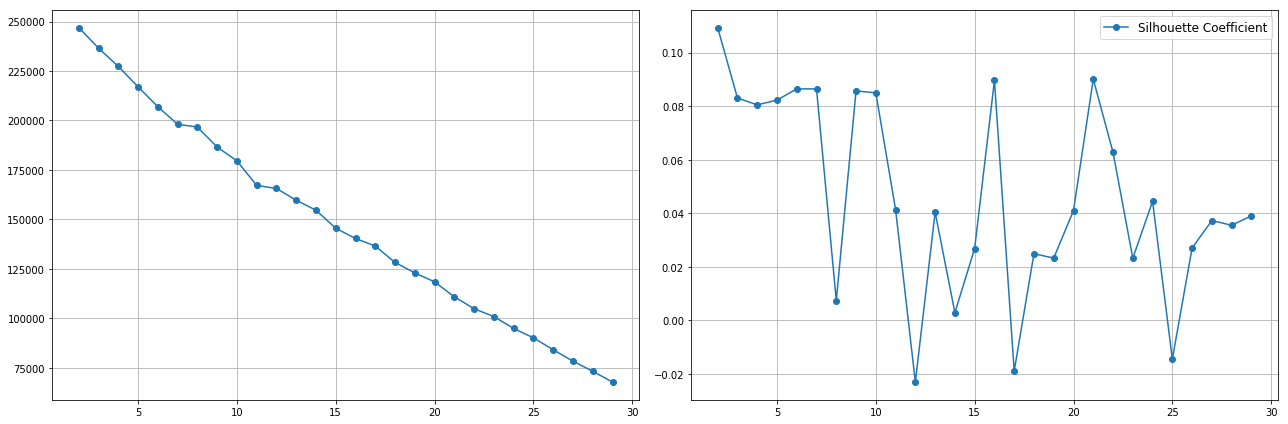

In [16]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

It seems 12,16,25 clusters are the best choice (12 seems a bit more preferable). Now, let's apply PCA on the data and visualize the data.

In [17]:
# build K-Means model
kmeans = KMeans(n_clusters=12, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [18]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

In [21]:
pca_feature.shape

(48, 2)

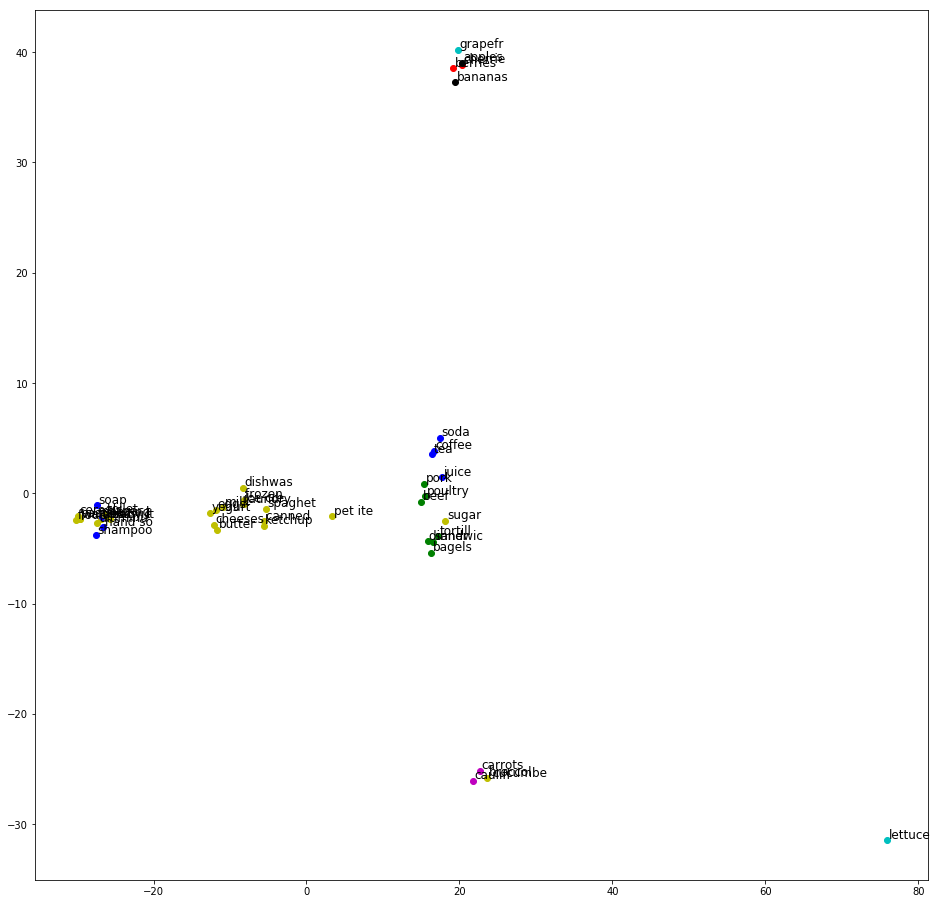

In [35]:
# visualization in 2D

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    #print(name.values[0][0])
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0][:7], fontsize=12)

plt.show()

In [36]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

(0, '\t', ['shampoo', 'shaving cream', 'hand soap', 'soap'])
(1, '\t', ['bagels', 'tortillas', 'dinner rolls', 'sandwich loaves'])
(2, '\t', ['cherries'])
(3, '\t', ['lettuce'])
(4, '\t', ['carrots', 'cauliflower'])
(5, '\t', ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xc2\xa0', 'canned vegetables', 'flour', 'pasta', 'toilet paper', 'ice cream', 'ketchup', 'broccoli', 'yogurt'])
(6, '\t', ['apples', 'bananas'])
(7, '\t', ['cucumbers'])
(8, '\t', ['soda', 'tea', 'juice', 'coffee'])
(9, '\t', ['poultry', 'beef', 'pork'])
(10, '\t', ['berries'])
(11, '\t', ['grapefruit'])
(12, '\t', [])
(13, '\t', [])
(14, '\t', [])
(15, '\t', [])
(16, '\t', [])
(17, '\t', [])
(18, '\t', [])
(19, '\t', [])
(20, '\t', [])


Above clustering is based on the raw feature, namely the user purchase for each item. There are other methods for this problem. For example, this notebook contains another method: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb.

With 12 clusters, some cluster looks very weird. Since there are only 48 different items, with one business expert in related area, it only take a few time to manually determine the best cluster numbers.